In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
import warnings
warnings.simplefilter (action = 'ignore')

In [35]:
df = pd.read_csv('/kaggle/input/bank-customer-churn/botswana_bank_customer_churn.csv')

 Veri setini yükle
 pd.read_csv() fonksiyonu, belirtilen CSV dosyasını okur ve bir DataFrame olarak yükler

# Keşifsel Veri Analizi (EDA)

In [36]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          115640 non-null  object 
 12  Co


 df.info() metodu, DataFrame'in genel bilgilerini (sütun isimleri, veri tipleri, null olmayan değer sayıları) gösterir.
 
 df.describe() metodu, sayısal sütunlar için temel istatistikleri (ortalama, standart sapma, min, max, çeyrekler) hesaplar



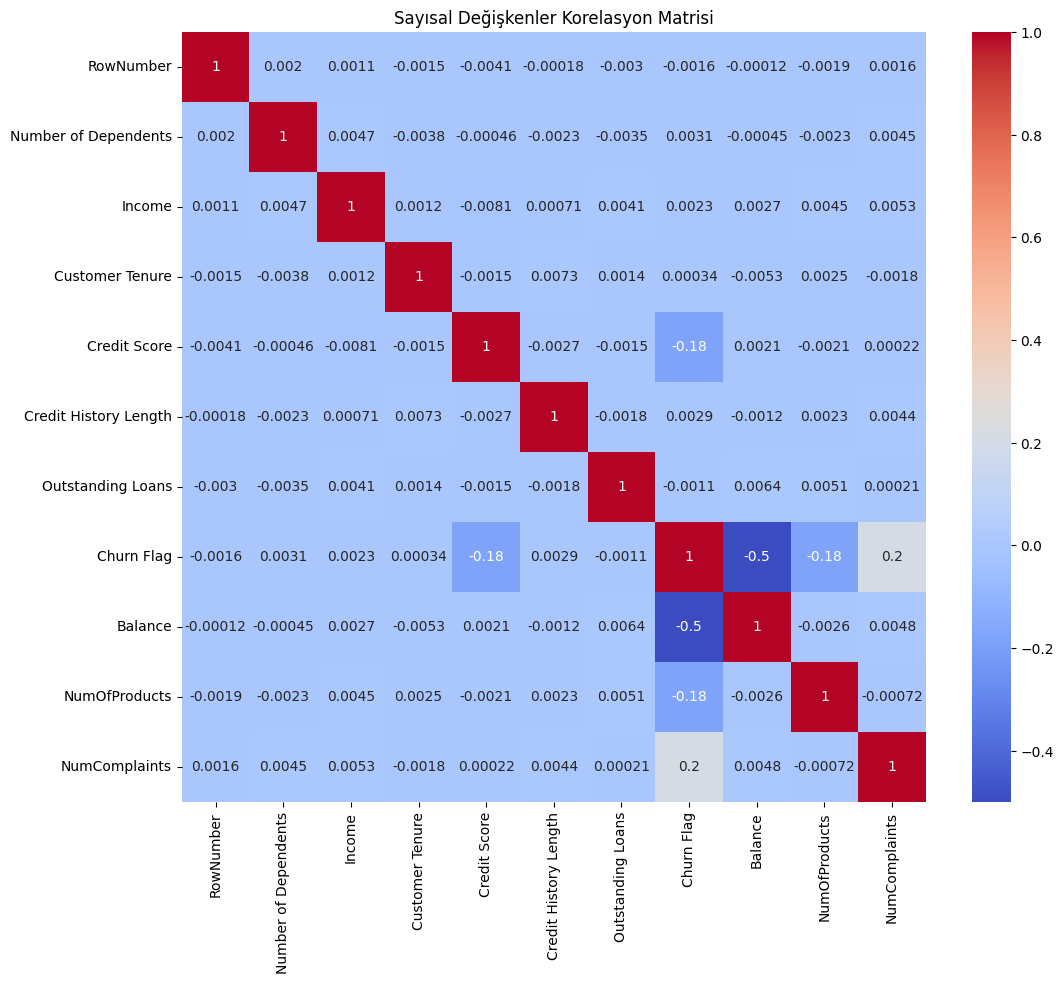

In [37]:
# Korelasyon matrisi

plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Sayısal Değişkenler Korelasyon Matrisi')
plt.show()

 plt.figure() fonksiyonu yeni bir çizim alanı oluşturur, figsize parametresi bu alanın boyutunu belirler
 df.select_dtypes() metodu, belirli veri tiplerindeki sütunları seçer
 corr() metodu, seçilen sayısal sütunlar arasındaki Pearson korelasyon katsayılarını hesaplar
 sns.heatmap() fonksiyonu, korelasyon matrisini renk kodlu bir ısı haritası olarak görselleştirir

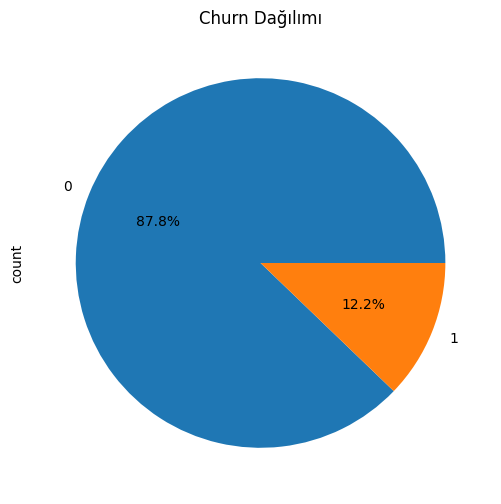

In [38]:
# Churn dağılımı
plt.figure(figsize=(8, 6))
df['Churn Flag'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Churn Dağılımı')
plt.show()

 value_counts() metodu, 'Churn Flag' sütunundaki benzersiz değerlerin frekansını hesaplar
 plot(kind='pie') metodu, bu frekansları pasta grafik olarak çize

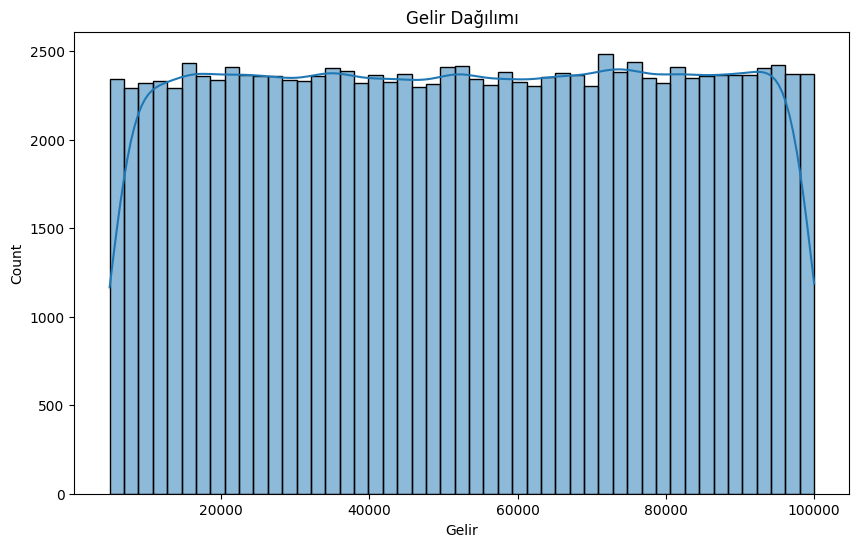

In [39]:
# Gelir dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True)
plt.title('Gelir Dağılımı')
plt.xlabel('Gelir')
plt.show()

 sns.histplot() fonksiyonu, 'Income' sütunu için bir histogram çizer
 kde=True parametresi, histograma bir yoğunluk tahmini eğrisi ekler

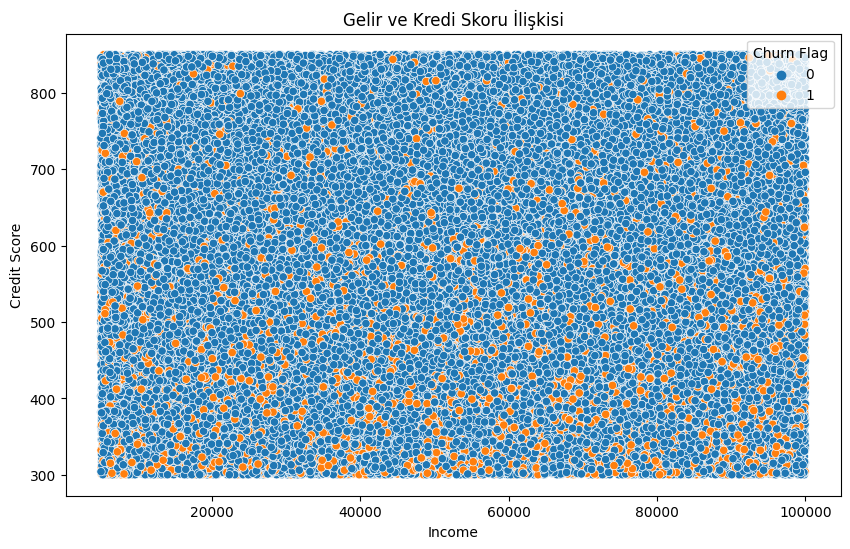

In [40]:
# Gelir ve Kredi Skoru ilişkisi
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Credit Score', hue='Churn Flag', data=df)
plt.title('Gelir ve Kredi Skoru İlişkisi')
plt.show()

 sns.scatterplot() fonksiyonu, 'Income' ve 'Credit Score' arasında bir dağılım grafiği çizer
 'Churn Flag' sütunu, noktaların rengini belirlemek için kullanılı

# Veri Ön İşleme

In [41]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Address', 'Contact Information'], axis=1)

 drop() metodu, belirtilen sütunları DataFrame'den kaldırır

In [42]:
df.columns

Index(['First Name', 'Date of Birth', 'Gender', 'Marital Status',
       'Number of Dependents', 'Occupation', 'Income', 'Education Level',
       'Customer Tenure', 'Customer Segment',
       'Preferred Communication Channel', 'Credit Score',
       'Credit History Length', 'Outstanding Loans', 'Churn Flag',
       'Churn Reason', 'Churn Date', 'Balance', 'NumOfProducts',
       'NumComplaints'],
      dtype='object')

In [43]:
# Kategorik değişkenleri sayısala çevir
le = LabelEncoder()
categorical_cols = ['First Name', 'Gender', 'Marital Status', 'Occupation', 'Education Level', 
                    'Customer Segment', 'Preferred Communication Channel', 'Churn Reason']
# LabelEncoder, her bir kategorik sütunu sayısal değerlere dönüştürür
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [44]:
# Tarih sütunlarını işle
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce').dt.year
df['Churn Date'] = pd.to_datetime(df['Churn Date'], errors='coerce').dt.year

 to_datetime() fonksiyonu, tarih string'lerini datetime nesnelerine dönüştürür
 dt.year özelliği, sadece yıl bilgisini alır

In [45]:
# NaN değerleri doldur
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

 SimpleImputer, eksik değerleri belirtilen strateji ile (burada ortalama) doldurur

In [46]:
# Özellik ölçeklendirme
scaler = StandardScaler()
numeric_cols = ['Income', 'Credit Score', 'Balance', 'Outstanding Loans']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

 StandardScaler, özellikleri standartlaştırır (ortalama=0, varyans=1)

In [47]:
# Veri setini eğitim ve test olarak böl
X = df.drop('Churn Flag', axis=1)
y = df['Churn Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Veri ön işleme tamamlandı.")
print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Veri ön işleme tamamlandı.
Eğitim seti boyutu: (92512, 19)
Test seti boyutu: (23128, 19)


 train_test_split() fonksiyonu, veri setini eğitim ve test setlerine böler

# Gözetimli Öğrenme: Lojistik Regresyon

In [48]:
# Gözetimli Öğrenme: Lojistik Regresyon
# Normal Lojistik Regresyon
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

LogisticRegression sınıfından bir model nesnesi oluşturur.
max_iter parametresi, modelin maksimum 1000 iterasyon yapmasını sağlar.
solver parametresi, 'liblinear' optimizasyon algoritmasını kullanır.
fit() metodu ile model, eğitim verileri (X_train ve y_train) üzerinde eğitilir.

# Lojistik Regresyon Değerlendirme

In [49]:
# Normal Lojistik Regresyon Değerlendirme
y_pred = lr_model.predict(X_test)
print("Normal Lojistik Regresyon Doğruluk:", accuracy_score(y_test, y_pred))
print("Normal Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))
print("Normal Karışıklık Matrisi:\n", confusion_matrix(y_test, y_pred))

Normal Lojistik Regresyon Doğruluk: 1.0
Normal Sınıflandırma Raporu:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20301
         1.0       1.00      1.00      1.00      2827

    accuracy                           1.00     23128
   macro avg       1.00      1.00      1.00     23128
weighted avg       1.00      1.00      1.00     23128

Normal Karışıklık Matrisi:
 [[20301     0]
 [    0  2827]]


Eğitilmiş modeli test verileri üzerinde kullanarak tahminler yapar.
Modelin doğruluğunu hesaplar ve yazdırır.
Sınıflandırma raporunu oluşturur (precision, recall, f1-score ve support değerlerini içerir).
Karışıklık matrisini (confusion matrix) oluşturur.

# Hiperparametre Optimizasyonu ile Lojistik Regresyon

In [50]:

lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)
print("En iyi Lojistik Regresyon parametreleri:", lr_grid.best_params_)
lr_best = lr_grid.best_estimator_

En iyi Lojistik Regresyon parametreleri: {'C': 0.01, 'penalty': 'l1'}


C (düzenlileştirme parametresi) ve penalty (ceza türü) için farklı değerler belirler.
GridSearchCV kullanarak, belirlenen hiperparametreler için çapraz doğrulama ile en iyi kombinasyonu arar.
En iyi parametreleri yazdırır ve en iyi modeli saklar.


# Optimize Edilmiş Lojistik Regresyon Değerlendirme

In [51]:

y_pred_opt = lr_best.predict(X_test)
print("Optimize Edilmiş Lojistik Regresyon Doğruluk:", accuracy_score(y_test, y_pred_opt))
print("Optimize Edilmiş Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_opt))
print("Optimize Edilmiş Karışıklık Matrisi:\n", confusion_matrix(y_test, y_pred_opt))

Optimize Edilmiş Lojistik Regresyon Doğruluk: 1.0
Optimize Edilmiş Sınıflandırma Raporu:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20301
         1.0       1.00      1.00      1.00      2827

    accuracy                           1.00     23128
   macro avg       1.00      1.00      1.00     23128
weighted avg       1.00      1.00      1.00     23128

Optimize Edilmiş Karışıklık Matrisi:
 [[20301     0]
 [    0  2827]]


Optimize edilmiş modeli test verileri üzerinde kullanır.
Modelin doğruluğunu, sınıflandırma raporunu ve karışıklık matrisini hesaplar ve yazdırır.

# Gözetimsiz Öğrenme: K-Means Kümeleme

In [52]:
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X)

3 küme (cluster) ile bir K-Means modeli oluşturur.
random_state parametresi, sonuçların tekrarlanabilir olmasını sağlar.
Veri setini (X) kullanarak modeli eğitir ve her veri noktası için küme etiketlerini tahmin eder.

# K-Means Kümeleme Değerlendirme

In [53]:
silhouette_avg = silhouette_score(X, kmeans_labels)
print("Normal K-Means Silhouette Skoru:", silhouette_avg)

Normal K-Means Silhouette Skoru: 0.3815372757752117


Silhouette skoru hesaplayarak kümeleme performansını değerlendirir.
Skor 0.382 civarında çıkmıştır, bu orta düzeyde bir kümeleme kalitesini gösterir.

# Hiperparametre Optimizasyonu ile K-Means

In [54]:
kmeans_params = {'n_clusters': [2, 3, 4, 5], 'init': ['k-means++', 'random']}
kmeans_grid = GridSearchCV(KMeans(), kmeans_params, cv=5)
kmeans_grid.fit(X)
kmeans_best = kmeans_grid.best_estimator_

Farklı küme sayıları (2 ila 5 arası) ve başlangıç noktası seçim yöntemleri için bir parametre grid'i oluşturur.
GridSearchCV kullanarak en iyi parametre kombinasyonunu bulmak için çapraz doğrulama yapar.
En iyi modeli bulmak için veri setini (X) kullanarak grid search'ü çalıştırır.

# Optimize Edilmiş K-Means Değerlendirme

In [55]:
kmeans_labels_opt = kmeans_best.fit_predict(X)
silhouette_avg_opt = silhouette_score(X, kmeans_labels_opt)
print("Optimize Edilmiş K-Means Silhouette Skoru:", silhouette_avg_opt)

Optimize Edilmiş K-Means Silhouette Skoru: 0.37393805832542376


Optimize edilmiş K-Means modelini kullanarak veri noktalarını kümelere atar.
Optimize edilmiş model için Silhouette skorunu hesaplar.
Sonuç olarak 0.37938 civarında bir skor elde edilmiştir, bu da orta düzeyde bir kümeleme kalitesini gösterir.

# Kümelerin görselleştirilmesi

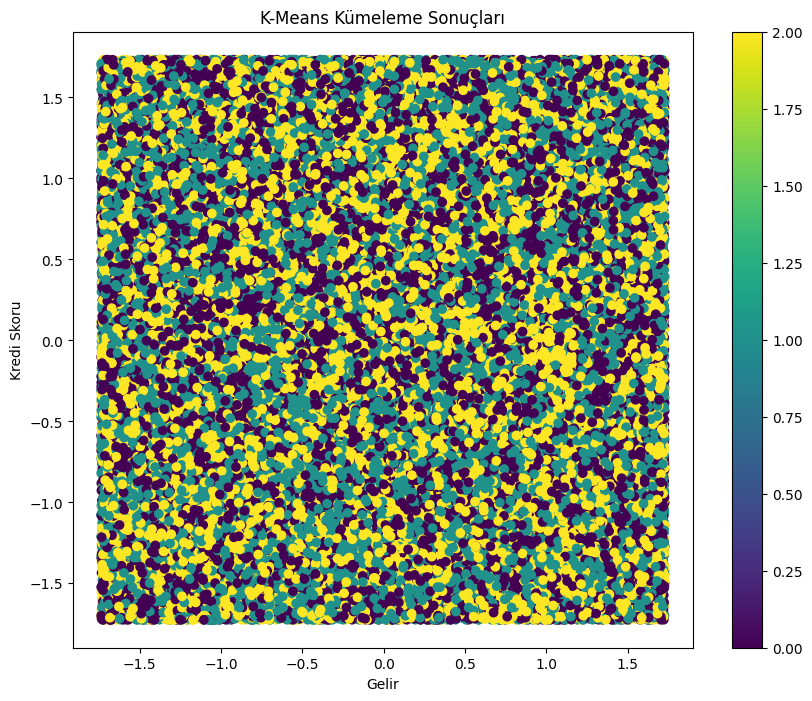

In [56]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X['Income'], X['Credit Score'], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Kümeleme Sonuçları')
plt.xlabel('Gelir')
plt.ylabel('Kredi Skoru')
plt.colorbar(scatter)
plt.show()

10x8 boyutunda bir grafik oluşturur.
Veri noktalarını 'Income' (Gelir) ve 'Credit Score' (Kredi Skoru) özelliklerine göre saçılım grafiğinde gösterir.
Her nokta, ait olduğu kümeye göre renklendirilir ('viridis' renk haritası kullanılarak).
Grafik başlığı, x ve y ekseni etiketleri eklenir.
Renk ölçeği (colorbar) eklenerek hangi rengin hangi kümeye ait olduğu gösterilir.

Görselleştirme sonucunda:

Grafik, gelir ve kredi skoru arasındaki ilişkiyi göstermektedir.
Farklı renkler farklı kümeleri temsil eder.
Noktaların dağılımı ve renkleri, veri setindeki grupları ve potansiyel örüntüleri gösterir.
Kümelerin net bir şekilde ayrılmadığı, birbirleriyle önemli ölçüde örtüştüğü görülmektedir. Bu durum, veri setindeki grupların belirgin sınırlarının olmadığını ve kümeleme görevinin zorluğunu gösterir.